In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers

from datetime import datetime, timedelta
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
dfd = pd.read_csv('daily_weather_data_v6.csv')
dfc = dfd[dfd['Station Name']=='COMOX A'].sort_values(by='Date/Time')\
        [['Station Name', 'Date/Time', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',
          'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)']].copy()

C:\Users\bansa\AppData\Local\Temp\ipykernel_9784\125678437.py:1: DtypeWarning: Columns (9,11,13,15,17,29) have mixed types. Specify dtype option on import or set low_memory=False.
  dfd = pd.read_csv('daily_weather_data_v6.csv')


In [4]:
dfc = pd.read_csv('data/Daily_COMOX A_155.csv')[['Station Name', 'Date/Time', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',
          'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)']]

C:\Users\bansa\AppData\Local\Temp\ipykernel_9784\2546309725.py:1: DtypeWarning: Columns (11,15,17,19,31) have mixed types. Specify dtype option on import or set low_memory=False.
  dfc = pd.read_csv('data/Daily_COMOX A_155.csv')[['Station Name', 'Date/Time', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',


In [5]:
dfh = pd.read_csv('comox_hour.csv')

C:\Users\bansa\AppData\Local\Temp\ipykernel_9784\4134861027.py:1: DtypeWarning: Columns (11,13,15,19,21,25,29) have mixed types. Specify dtype option on import or set low_memory=False.
  dfh = pd.read_csv('comox_hour.csv')


In [6]:
len(pd.date_range(start = dfc['Date/Time'].min(), end = dfc['Date/Time'].max()).difference(dfc['Date/Time']))

29

In [7]:
len(pd.date_range(start = dfh['Date/Time (LST)'].min(), end = dfh['Date/Time (LST)'].max()).difference(dfh['Date/Time (LST)']))

0

### Daily data for Temp and Wind

In [8]:
dfc.columns

Index(['Station Name', 'Date/Time', 'Max Temp (°C)', 'Min Temp (°C)',
       'Mean Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)',
       'Total Precip (mm)'],
      dtype='object')

In [9]:
dfc.isnull().sum()*100/dfh.shape[0]

Station Name         0.000000
Date/Time            0.000000
Max Temp (°C)        0.000000
Min Temp (°C)        0.000000
Mean Temp (°C)       0.000000
Total Rain (mm)      0.000000
Total Snow (cm)      0.000321
Total Precip (mm)    0.000000
dtype: float64

In [10]:
max(dfc['Date/Time'])

'2023-11-18'

In [12]:
dfs = dfc.copy()
missing_dates = pd.Series(pd.date_range(start = dfs['Date/Time'].min(), end = dfs['Date/Time'].max()).difference(dfs['Date/Time'])).astype(str)
dfs = pd.concat([dfs, pd.DataFrame({'Date/Time': missing_dates})])
dfs['Date/Time'] = pd.to_datetime(dfs['Date/Time'])
dfs.sort_values('Date/Time', inplace=True)
data = dfs.interpolate('ffill')

In [13]:
data.columns

Index(['Station Name', 'Date/Time', 'Max Temp (°C)', 'Min Temp (°C)',
       'Mean Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)',
       'Total Precip (mm)'],
      dtype='object')

In [14]:
target = ['Mean Temp (°C)']

sequence_length = 365

data_sequences = []
target_data = []

for i in range(len(data) - sequence_length):
    data_sequences.append(data[target].values[i:i+sequence_length])
    target_data.append(data[target].values[i+sequence_length])

data_sequences = np.array(data_sequences)
target_data = np.array(target_data)

X_train, X_test, y_train, y_test = train_test_split(data_sequences, target_data, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(data_sequences, target_data, test_size=0.2, shuffle=False)

In [15]:
X_train.shape, X_test.shape, X_val.shape

((20419, 365, 1), (2553, 365, 1), (5105, 365, 1))

In [16]:
model = keras.Sequential()
model.add(keras.layers.LSTM(64, input_shape=(sequence_length, 1)))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
639/639 [==============================] - 66s 101ms/step - loss: 12.2114 - mae: 2.2901 - val_loss: 3.5731 - val_mae: 1.4725
Epoch 2/10
639/639 [==============================] - 64s 100ms/step - loss: 3.4307 - mae: 1.4683 - val_loss: 3.0921 - val_mae: 1.3839
Epoch 3/10
639/639 [==============================] - 63s 98ms/step - loss: 3.2783 - mae: 1.4392 - val_loss: 2.8332 - val_mae: 1.3323
Epoch 4/10
639/639 [==============================] - 63s 98ms/step - loss: 3.2093 - mae: 1.4262 - val_loss: 2.8739 - val_mae: 1.3424
Epoch 5/10
639/639 [==============================] - 62s 97ms/step - loss: 3.1675 - mae: 1.4161 - val_loss: 2.7758 - val_mae: 1.3244
Epoch 6/10
639/639 [==============================] - 63s 98ms/step - loss: 3.1598 - mae: 1.4166 - val_loss: 2.7566 - val_mae: 1.3172
Epoch 7/10
639/639 [==============================] - 63s 99ms/step - loss: 3.1674 - mae: 1.4169 - val_loss: 2.8258 - val_mae: 1.3335
Epoch 8/10
639/639 [==============================] - 61s 9

In [17]:
# validation accuracy
pval = model.predict(X_val)

print(f"MAE\t: {np.mean(np.abs(pval - y_val))}")

print(f"MSE\t: {mean_squared_error(y_val, pval)}")

print(f"R2\t: {r2_score(y_val, pval)}")

160/160 [==============================] - 6s 34ms/step
MAE	: 1.3257989933231553
MSE	: 2.8092917832149076
R2	: 0.9282058622278957


80/80 [==============================] - 3s 34ms/step
MAE	: 1.3735270066957965
MSE	: 3.0384394111984947
R2	: 0.9291289584425677


<Axes: xlabel='Date/Time'>

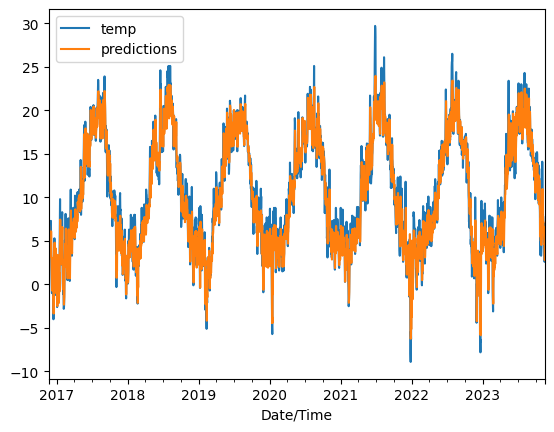

In [18]:
# Testing accuracy
predictions = model.predict(X_test)

print(f"MAE\t: {np.mean(np.abs(predictions - y_test))}")

print(f"MSE\t: {mean_squared_error(y_test, predictions)}")

print(f"R2\t: {r2_score(y_test, predictions)}")

r = pd.DataFrame(index=data['Date/Time'][-len(predictions):], data={'temp': y_test.flatten(), 'predictions': predictions.flatten()})
r.plot()

In [ ]:
# Future predictions (1 year)
sequence_length = 365
target = ['Mean Temp (°C)']

last_sequence = data[target].values[-sequence_length:]

n_future_steps = 365

extended_sequence = last_sequence.copy()

for i in range(n_future_steps):
    sequence = extended_sequence[-sequence_length:].reshape(1, sequence_length, 1)
    
    next_prediction = model.predict(sequence)
    
    extended_sequence = np.append(extended_sequence, next_prediction)

predicted_future = extended_sequence[-n_future_steps:]

In [20]:
future_timestamps = pd.date_range(start=max(data['Date/Time']), periods=n_future_steps + 1, closed='right')

C:\Users\bansa\AppData\Local\Temp\ipykernel_9784\4099626314.py:1: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_timestamps = pd.date_range(start=max(data['Date/Time']), periods=n_future_steps + 1, closed='right')


<Axes: >

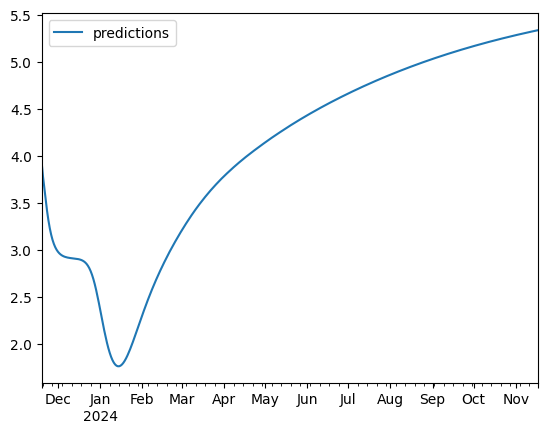

In [21]:
predicted_future_df = pd.DataFrame(index=future_timestamps, data={'predictions': predicted_future})
predicted_future_df.plot()

In [22]:
z = predicted_future_df.reset_index()
z.columns = ['Date/Time', 'Mean Temp (°C)']
z['Station Name'] = 'COMOX A'
z

,Date/Time,Mean Temp (°C),Station Name
0,2023-11-19,3.939943,COMOX A
1,2023-11-20,3.784114,COMOX A
2,2023-11-21,3.659380,COMOX A
3,2023-11-22,3.532148,COMOX A
4,2023-11-23,3.415736,COMOX A
...,...,...,...
360,2024-11-13,5.323245,COMOX A
361,2024-11-14,5.326406,COMOX A
362,2024-11-15,5.329548,COMOX A
363,2024-11-16,5.332671,COMOX A


In [24]:
data

,Station Name,Date/Time,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm)
25495,COMOX A,1953-01-01,5.6,-1.1,2.3,4.3,0.0,4.3
25496,COMOX A,1953-01-02,5.6,2.8,4.2,16.5,0.0,16.5
25497,COMOX A,1953-01-03,8.9,3.9,6.4,0.0,0.0,0.0
25498,COMOX A,1953-01-04,6.7,3.3,5.0,0.0,0.0,0.0
25499,COMOX A,1953-01-05,4.4,2.2,3.3,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
317,COMOX A,2023-11-14,8.1,1.0,4.6,0.0,0.0,0.0
318,COMOX A,2023-11-15,7.6,1.7,4.7,1.8,0.0,1.8
319,COMOX A,2023-11-16,6.4,-1.2,2.6,0.0,0.0,0.0
320,COMOX A,2023-11-17,8.2,1.5,4.9,0.0,0.0,0.0


In [179]:
zz = pd.merge(zz, z, on=['Station Name','Date/Time'])
zz

,Station Name,Date/Time,Mean Temp (°C),Max Temp (°C),Min Temp (°C),Total Rain (mm),Total Snow (cm)
0,COMOX A,2023-11-14,6.142968,9.427223,3.300698,7.197880,0.148358
1,COMOX A,2023-11-15,6.620000,9.848145,3.928416,7.490841,0.309443
2,COMOX A,2023-11-16,6.844569,10.045302,4.128850,7.311282,0.500603
3,COMOX A,2023-11-17,6.939100,10.110209,4.174058,7.123498,0.726946
4,COMOX A,2023-11-18,6.976707,10.105835,4.167123,6.908137,0.939199
...,...,...,...,...,...,...,...
360,COMOX A,2024-11-08,5.510803,14.013565,4.335409,2.700352,4.325090
361,COMOX A,2024-11-09,5.463128,13.891331,4.284915,2.664041,4.325090
362,COMOX A,2024-11-10,5.399553,13.773273,4.227387,2.617318,4.325090
363,COMOX A,2024-11-11,5.323875,13.658855,4.165260,2.583813,4.325090


In [181]:
zzz = pd.concat([data, zz], ignore_index=True)
zzz

,Station Name,Date/Time,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm)
0,COMOX A,1953-01-01,5.600000,-1.100000,2.300000,4.300000,0.00000,4.3
1,COMOX A,1953-01-02,5.600000,2.800000,4.200000,16.500000,0.00000,16.5
2,COMOX A,1953-01-03,8.900000,3.900000,6.400000,0.000000,0.00000,0.0
3,COMOX A,1953-01-04,6.700000,3.300000,5.000000,0.000000,0.00000,0.0
4,COMOX A,1953-01-05,4.400000,2.200000,3.300000,0.000000,0.00000,0.0
...,...,...,...,...,...,...,...,...
26244,COMOX A,2024-11-08,14.013565,4.335409,5.510803,2.700352,4.32509,NaN
26245,COMOX A,2024-11-09,13.891331,4.284915,5.463128,2.664041,4.32509,NaN
26246,COMOX A,2024-11-10,13.773273,4.227387,5.399553,2.617318,4.32509,NaN
26247,COMOX A,2024-11-11,13.658855,4.165260,5.323875,2.583813,4.32509,NaN


In [182]:
zzz.to_csv('comox pred full.csv')

<Axes: xlabel='Date/Time'>

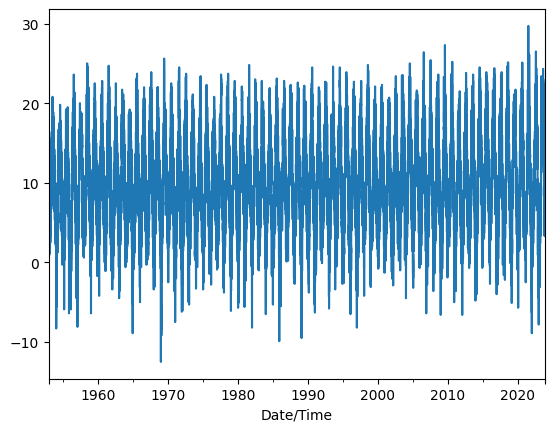

In [21]:
data.set_index(['Date/Time'], drop=True)['Mean Temp (°C)'].plot()